<a href="https://colab.research.google.com/github/ZhiquanW/Learn-CUDA-Repository/blob/master/Copy_of_udacity_cs344_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd /content/
! rm -fr udacity-cs344-colab/
! ls

/content
sample_data


   Udacity Homework 3
   HDR Tone-mapping

  Background HDR
  ==============

  A High Dynamic Range (HDR) image contains a wider variation of intensity
  and color than is allowed by the RGB format with 1 byte per channel that we
  have used in the previous assignment.

  To store this extra information we use single precision floating point for
  each channel.  This allows for an extremely wide range of intensity values.

  In the image for this assignment, the inside of church with light coming in
  through stained glass windows, the raw input floating point values for the
  channels range from 0 to 275.  But the mean is .41 and 98% of the values are
  less than 3!  This means that certain areas (the windows) are extremely bright
  compared to everywhere else.  If we linearly map this [0-275] range into the
  [0-255] range that we have been using then most values will be mapped to zero!
  The only thing we will be able to see are the very brightest areas - the
  windows - everything else will appear pitch black.

  The problem is that although we have cameras capable of recording the wide
  range of intensity that exists in the real world our monitors are not capable
  of displaying them.  Our eyes are also quite capable of observing a much wider
  range of intensities than our image formats / monitors are capable of
  displaying.

  Tone-mapping is a process that transforms the intensities in the image so that
  the brightest values aren't nearly so far away from the mean.  That way when
  we transform the values into [0-255] we can actually see the entire image.
  There are many ways to perform this process and it is as much an art as a
  science - there is no single "right" answer.  In this homework we will
  implement one possible technique.

  Background Chrominance-Luminance
  ================================

  The RGB space that we have been using to represent images can be thought of as
  one possible set of axes spanning a three dimensional space of color.  We
  sometimes choose other axes to represent this space because they make certain
  operations more convenient.

  Another possible way of representing a color image is to separate the color
  information (chromaticity) from the brightness information.  There are
  multiple different methods for doing this - a common one during the analog
  television days was known as Chrominance-Luminance or YUV.

  We choose to represent the image in this way so that we can remap only the
  intensity channel and then recombine the new intensity values with the color
  information to form the final image.

  Old TV signals used to be transmitted in this way so that black & white
  televisions could display the luminance channel while color televisions would
  display all three of the channels.


  Tone-mapping
  ============

  In this assignment we are going to transform the luminance channel (actually
  the log of the luminance, but this is unimportant for the parts of the
  algorithm that you will be implementing) by compressing its range to [0, 1].
  To do this we need the cumulative distribution of the luminance values.

  Example
  -------

  input : [2 4 3 3 1 7 4 5 7 0 9 4 3 2]
  min / max / range: 0 / 9 / 9

  histo with 3 bins: [4 7 3]

  cdf : [4 11 14]


  Your task is to calculate this cumulative distribution by following these
  steps.


In [2]:
# Homework 3 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+git://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW3"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 144 (delta 43), reused 100 (delta 28), pack-reused 0
Receiving objects: 100% (144/144), 3.94 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Cloning git://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-un618z4b
  Running command git clone -q git://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-un618z4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-m4ug41f_/wheels/1e/43/2d/099cad2b9b02dfa88573f50a22735d8a0b2ba69bf82167b81c
Successfully built NVCCPlugin
Set up cuda environment at /content/udacity-cs344-colab/src/HW3
Default out bin result.out
/content/udacity-cs344-colab/build
-- The C compiler identification is GNU 7.3.0
-- The CXX compiler identification is GNU 7.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- wo

In [44]:
%%cuda --name student_func.cu
//%%cuda --name student_func.cu
#include "utils.h"
#include <iostream>
    using namespace std;
__global__ void switch_value_per_block(const float *const d_logLuminance,
                                       float *const d_switched_logLuminance,
                                       const size_t arr_len);

__global__ void find_min_max_per_block(
    const float *const d_switched_logLuminance, const size_t arr_len,
    float *const d_min_arr, float *const d_max_arr);

__global__ void find_min_max_global(float *const d_min_arr,
                                    float *const d_max_arr,
                                    const size_t arr_len);

__global__ void compute_histo_bins(const float *const d_logLuminance,
                                   const size_t arr_len,
                                   unsigned int *const d_histo_bins,
                                   const size_t num_bins,
                                   const float min_logLum,
                                   const float max_logLum);

__global__ void pre_scan_histo(const unsigned int *const d_histo_bins,
                               const size_t num_bins, unsigned int *const d_cdf,
                               unsigned int *const d_sums);

__global__ void post_scan_histo(unsigned int *const d_cdf,
                                const size_t num_bins,
                                unsigned int *const d_sums,
                                const size_t sums_len) ;
void your_histogram_and_prefixsum(const float *const d_logLuminance,
                                  unsigned int *const d_cdf, float &min_logLum,
                                  float &max_logLum, const size_t numRows,
                                  const size_t numCols, const size_t numBins) {
    // TODO
    /*Here are the steps you need to implement
      1) find the minimum and maximum value in the input logLuminance channel
         store in min_logLum and max_logLum
      2) subtract them to find the range
      3) generate a histogram of all the values in the logLuminance channel
      using the formula: bin = (lum[i] - lumMin) / lumRange * numBins
      4) Performan exclusive scan (prefix sum) on the histogram to get the
      cumulative
      distribution of luminance values (this should go in the incoming d_cdf
      pointer which already has been allocated for you)
    */
    cout << "start GPU" << endl;
    // find min & max value
    //# Image Parameters
    const size_t arr_len = numRows * numCols;
    //# Set up grid & block size
    const int block_len = 512;
    const dim3 block_size(block_len);
    const int grid_len = (arr_len - 1) / block_len + 1;
    const dim3 grid_size(grid_len);

    //# Allocate device memory for switch_value_per_block()
    float *d_switched_logLuminance;
    checkCudaErrors(
        cudaMalloc(&d_switched_logLuminance, sizeof(float) * arr_len));
    //# Call Device Funtions : Switch Min & Max for the first time
    switch_value_per_block<<<grid_size, block_size,
                             sizeof(float) * block_size.x>>>(
        d_logLuminance, d_switched_logLuminance, arr_len);
    //# Allocate device memory for find_min_max_per_block()
    float *d_min_arr;
    float *d_max_arr;
    checkCudaErrors(cudaMalloc(&d_min_arr, sizeof(float) * grid_len));
    checkCudaErrors(cudaMalloc(&d_max_arr, sizeof(float) * grid_len));

    //# Call Device Funtions : find_min_max_per_block
    find_min_max_per_block<<<grid_size, block_size,
                             sizeof(float) * block_size.x>>>(
        d_switched_logLuminance, arr_len, d_min_arr, d_max_arr);
    checkCudaErrors(cudaFree(d_switched_logLuminance));
    find_min_max_global<<<1, grid_len, sizeof(float) * grid_len * 2>>>(
        d_min_arr, d_max_arr, grid_len);
 cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
    //# Copy switched date back to CPU
    checkCudaErrors(cudaMemcpy(&min_logLum, d_min_arr, sizeof(float),
                               cudaMemcpyDeviceToHost));
    checkCudaErrors(cudaMemcpy(&max_logLum, d_max_arr, sizeof(float),
                               cudaMemcpyDeviceToHost));

    checkCudaErrors(cudaFree(d_min_arr));
    checkCudaErrors(cudaFree(d_max_arr));
    unsigned int *d_histo_bins;
    checkCudaErrors(cudaMalloc(&d_histo_bins, sizeof(unsigned int) * numBins));
    checkCudaErrors(
        cudaMemset(d_histo_bins, 0, sizeof(unsigned int) * numBins));
    compute_histo_bins<<<grid_size, block_size>>>(
        d_logLuminance, arr_len, d_histo_bins, numBins, min_logLum, max_logLum);
 cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
    unsigned int *d_sums;
    checkCudaErrors(cudaMalloc(&d_sums, sizeof(unsigned int) * grid_len));
    const size_t buffer_len = block_len * 2;
    pre_scan_histo<<<dim3(grid_len / 2), block_size,
                     sizeof(unsigned int) * buffer_len>>>(d_histo_bins, numBins,
                                                          d_cdf, d_sums);
     cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
    post_scan_histo<<<dim3(1), dim3(512), sizeof(unsigned int) * 1024>>>(
        d_cdf, numBins, d_sums, grid_len);
     cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
    /*
    unsigned int *h_histo_bins = new unsigned int[numBins];
    checkCudaErrors(cudaMemcpy(h_histo_bins, d_histo_bins,
                               sizeof(unsigned int) * numBins,
                               cudaMemcpyDeviceToHost));

    unsigned int *h_cdf = new unsigned int[numBins];
    h_cdf[0] = 0;
    for (int i = 1; i < numBins; ++i) {
        h_cdf[i] = h_histo_bins[i - 1] + h_cdf[i - 1];
    }
    checkCudaErrors(cudaMemcpy(d_cdf, h_cdf, sizeof(unsigned int) * numBins,
                               cudaMemcpyHostToDevice));
    */
    cout << "end" << endl;
}

__global__ void switch_value_per_block(const float *const d_logLuminance,
                                       float *const d_switched_logLuminance,
                                       const size_t arr_len) {
    //# Set up shared memory
    extern __shared__ float s_logLuminance[];
    // Set up index
    int g_arr_index = threadIdx.x + blockIdx.x * blockDim.x;
    int s_arr_index = threadIdx.x;
    if (g_arr_index >= arr_len) {
        return;
    }
    //# Copy from global memory to shared memory
    s_logLuminance[s_arr_index] = d_logLuminance[g_arr_index];
    __syncthreads();
    int tmp_arr_len = blockDim.x;
    if (blockIdx.x + 1 == gridDim.x) {
        tmp_arr_len = arr_len - blockIdx.x * blockDim.x;
    }
    //# switch values
    if (s_arr_index < tmp_arr_len / 2) {
        int min_index = s_arr_index + tmp_arr_len / 2;
        if (s_logLuminance[s_arr_index] > s_logLuminance[min_index]) {
            float tmp_v = s_logLuminance[min_index];
            s_logLuminance[min_index] = s_logLuminance[s_arr_index];
            s_logLuminance[s_arr_index] = tmp_v;
        }
    }
    __syncthreads();

    //# write shared memory data back to global memory
    d_switched_logLuminance[g_arr_index] = s_logLuminance[s_arr_index];
}

__global__ void find_min_max_per_block(
    const float *const d_switched_logLuminance, const size_t arr_len,
    float *const d_min_arr, float *const d_max_arr) {
    //#copy data from global memory to shared memory
    extern __shared__ float s_logLuminance[];
    int g_arr_index = threadIdx.x + blockIdx.x * blockDim.x;
    int s_arr_index = threadIdx.x;
    if (g_arr_index >= arr_len) {
        return;
    }
    s_logLuminance[s_arr_index] = d_switched_logLuminance[g_arr_index];
    __syncthreads();

    int tmp_arr_len = blockDim.x;
    if (blockIdx.x + 1 == gridDim.x) {
        tmp_arr_len = arr_len - blockIdx.x * blockDim.x;
    }
    //#find min&max value in the block
    for (int interval = tmp_arr_len / 4; interval > 0; interval /= 2) {
        //##find min value & store in the head
        //## for the first loop, switch values
        if (s_arr_index < interval) {
            int min_index = s_arr_index + interval;
            // printf("%2f %2f %2f\n",s_arr_index,interval,min_index);
            if (s_logLuminance[s_arr_index] > s_logLuminance[min_index]) {
                s_logLuminance[s_arr_index] = s_logLuminance[min_index];
            }
        }

        //##find max value & store in the tail
        if (s_arr_index >= tmp_arr_len / 2 &&
            s_arr_index < tmp_arr_len / 2 + interval) {
            int max_index = s_arr_index + interval;
            if (s_logLuminance[s_arr_index] < s_logLuminance[max_index]) {
                s_logLuminance[s_arr_index] = s_logLuminance[max_index];
            }
        }
    }
    //!!# if arr len is odd, check the last value
    __syncthreads();
    // write data to global memory
    if (s_arr_index == 0) {
        d_min_arr[blockIdx.x] = s_logLuminance[s_arr_index];
    } else if (s_arr_index == tmp_arr_len / 2) {
        d_max_arr[blockIdx.x] = s_logLuminance[s_arr_index];
    }
}

__global__ void find_min_max_global(float *const d_min_arr,
                                    float *const d_max_arr,
                                    const size_t arr_len) {
    int index = threadIdx.x;
    extern __shared__ float shared_buffer[];
    float *const s_min_arr = &shared_buffer[0];
    float *const s_max_arr = &shared_buffer[blockDim.x];
    s_min_arr[index] = d_min_arr[index];
    s_max_arr[index] = d_max_arr[index];
    __syncthreads();
    for (int interval = arr_len / 2; interval > 0; interval /= 2) {
        if (index < interval) {
            if (s_min_arr[index] > s_min_arr[index + interval]) {
                s_min_arr[index] = s_min_arr[index + interval];
            }
            if (s_max_arr[index] < s_max_arr[index + interval]) {
                s_max_arr[index] = s_max_arr[index + interval];
            }
        }
        __syncthreads();
    }
    if (index == 0) {
        d_min_arr[index] = s_min_arr[index];
        d_max_arr[index] = s_max_arr[index];
    }
}

__global__ void compute_histo_bins(const float *const d_logLuminance,
                                   const size_t arr_len,
                                   unsigned int *const d_histo_bins,
                                   const size_t num_bins,
                                   const float min_logLum,
                                   const float max_logLum) {
    int g_index = threadIdx.x + blockIdx.x * blockDim.x;
    if (g_index >= arr_len) {
        return;
    }
    float logLum_range = max_logLum - min_logLum;
    unsigned int max_index = num_bins - 1;
    unsigned int tmp_index =
        (d_logLuminance[g_index] - min_logLum) / logLum_range * num_bins;
    unsigned int bin_index = max_index < tmp_index ? max_index : tmp_index;
    atomicAdd(&d_histo_bins[bin_index], 1);
}

__global__ void pre_scan_histo(const unsigned int *const d_histo_bins,
                               const size_t num_bins, unsigned int *const d_cdf,
                               unsigned int *const d_sums) {
    extern __shared__ unsigned int shared_arr[];  // len = 1024
    int t_id = threadIdx.x;
    int g_id = threadIdx.x + blockIdx.x * blockDim.x;
    if (2 * g_id < num_bins) {
        shared_arr[2 * t_id] = d_histo_bins[2 * g_id];

    } else {
        shared_arr[2 * t_id] = 0;
    }
    if (2 * g_id + 1 < num_bins) {
        shared_arr[2 * t_id + 1] = d_histo_bins[2 * g_id + 1];
    } else {
        shared_arr[2 * t_id + 1] = 0;
    }
    
    if(t_id < 100){
            printf("%d %d ",2 * g_id, shared_arr[2 * t_id]);
        }
    unsigned int offset = 1;
    for (unsigned int interval = blockDim.x >> 1; interval > 0;
         interval >>= 1) {
        __syncthreads();
        if (t_id < interval) {
            unsigned int pre_id = offset * (2 * t_id + 1) - 1;
            unsigned int post_id = offset * (2 * t_id + 2) - 1;
            shared_arr[post_id] += shared_arr[pre_id];
        }
        offset *= 2;
    }
    if (t_id == 0) shared_arr[blockDim.x - 1] = 0;
    for (int interval = 1; interval < blockDim.x; interval *= 2) {
        offset >>= 1;
        __syncthreads();
        if (t_id < interval) {
            unsigned int pre_id = offset * (2 * t_id + 1) - 1;
            unsigned int post_id = offset * (2 * t_id + 2) - 1;
            unsigned int tmp_v = shared_arr[pre_id];
            shared_arr[pre_id] = shared_arr[post_id];
            shared_arr[post_id] += tmp_v;
        }
    }
    __syncthreads();
    d_cdf[2 * g_id] = shared_arr[2 * t_id];
  
    d_cdf[2 * g_id + 1] = shared_arr[2 * t_id + 1];
    d_sums[blockIdx.x] = shared_arr[blockDim.x - 1];
}

__global__ void post_scan_histo(unsigned int *const d_cdf,
                                const size_t num_bins,
                                unsigned int *const d_sums,
                                const size_t sums_len) {
    extern __shared__ unsigned int shared_arr1[];
    int t_id = threadIdx.x;
    if (2 * t_id < sums_len) {
        shared_arr1[2 * t_id] = d_sums[t_id * 2];
    } else {
        shared_arr1[t_id] = 0;
    }
    if (2 * t_id + 1 < sums_len) {
        shared_arr1[2 * t_id + 1] = d_sums[t_id * 2 + 1];
    } else {
        shared_arr1[2 * t_id + 1] = 0;
    }
    int offset  =1;
    for (int interval = blockDim.x >> 1; interval > 0; interval >>= 1) {
        __syncthreads();
        if (t_id < interval) {
            unsigned int pre_id = offset * (2 * t_id + 1) - 1;
            unsigned int post_id = offset * (2 * t_id + 2) - 1;
            shared_arr1[post_id] += shared_arr1[pre_id];
        }
        offset *= 2;
    }
    if (t_id == 0) shared_arr1[blockDim.x - 1] = 0;
    for (int interval = 1; interval < blockDim.x; interval *= 2) {
        offset >>= 1;
        __syncthreads();
        if (t_id < interval) {
            unsigned int pre_id = offset * (2 * t_id + 1) - 1;
            unsigned int post_id = offset * (2 * t_id + 2) - 1;
            unsigned int tmp_v = shared_arr1[pre_id];
            shared_arr1[pre_id] = shared_arr1[post_id];
            shared_arr1[post_id] += tmp_v;
        }
    }
    __syncthreads();
    for (int id = 0; id < 512; ++id) {
        if(t_id * 2-id < num_bins){
                    d_cdf[t_id * 2 - id] = shared_arr1[2 * t_id];

        }
        if(t_id * 2 +1 -id < num_bins){
                    d_cdf[t_id * 2 + 1 - id] = shared_arr1[2 * t_id + 1];
        }
    }
}


'File written in /content/udacity-cs344-colab/src/HW3/student_func.cu'

In [45]:
# make the cuda project
!make HW3
print("\n====== RESULT OF HW3 =======\n")
!bin/HW3 ../src/HW3/memorial_png_large.gold

[ 14%] Building NVCC (Device) object HW3/CMakeFiles/HW3.dir/HW3_generated_student_func.cu.o
[ 28%] Linking CXX executable ../bin/HW3
[100%] Built target HW3

====== RESULT OF HW3 =======

start GPU
88192 0 88194 0 88196 0 88198 0 88200 0 88202 0 88204 0 88206 0 88208 0 88210 0 88212 0 88214 0 88216 0 88218 0 88220 0 88222 0 88224 0 88226 0 88228 0 88230 0 88232 0 88234 0 88236 0 88238 0 88240 0 88242 0 88244 0 88246 0 88248 0 88250 0 88252 0 88254 0 88128 0 88130 0 88132 0 88134 0 88136 0 88138 0 88140 0 88142 0 88144 0 88146 0 88148 0 88150 0 88152 0 88154 0 88156 0 88158 0 88160 0 88162 0 88164 0 88166 0 88168 0 88170 0 88172 0 88174 0 88176 0 88178 0 88180 0 88182 0 88184 0 88186 0 88188 0 88190 0 89280 0 89282 0 89284 0 89286 0 89152 0 89154 0 89156 0 89158 0 89160 0 89162 0 89164 0 89166 0 89168 0 89170 0 89172 0 89174 0 89176 0 89178 0 89180 0 89182 0 89184 0 89186 0 89188 0 89190 0 89192 0 89194 0 89196 0 89198 0 89200 0 89202 0 89204 0 89206 0 89208 0 89210 0 89212 0 89214 0 89

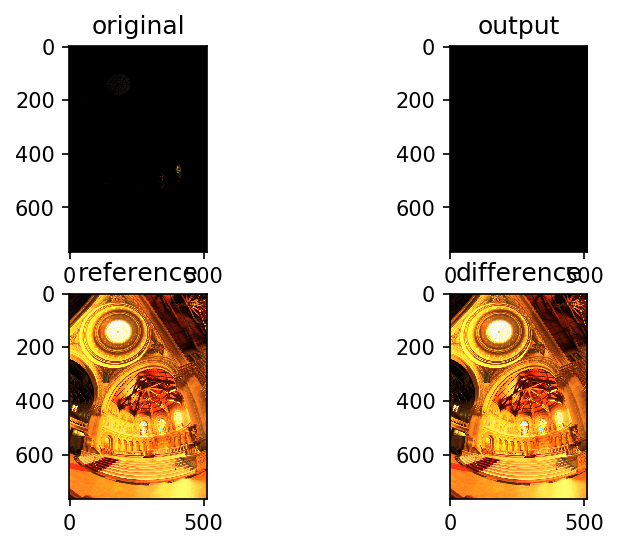

In [31]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW3/memorial_raw_large.png"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW3_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW3_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW3_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()